<a id="1"></a>
# **<center><span style="color:#005dc4;">Import Libraries</span></center>**

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
# **<center><span style="color:#005dc4;">Read Dataset</span></center>**

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Create Files_Name
image_data= "/content/drive/MyDrive/garbage_classification/garbage_classification/"
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,battery
1,biological
2,brown-glass
3,cardboard
4,clothes
5,green-glass
6,metal
7,paper
8,plastic
9,shoes


In [4]:
files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pan.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,/content/drive/MyDrive/garbage_classification/...,cardboard
1,/content/drive/MyDrive/garbage_classification/...,battery
2,/content/drive/MyDrive/garbage_classification/...,trash
3,/content/drive/MyDrive/garbage_classification/...,trash
4,/content/drive/MyDrive/garbage_classification/...,plastic
...,...,...
15510,/content/drive/MyDrive/garbage_classification/...,cardboard
15511,/content/drive/MyDrive/garbage_classification/...,trash
15512,/content/drive/MyDrive/garbage_classification/...,paper
15513,/content/drive/MyDrive/garbage_classification/...,plastic


<a id="3"></a>
# **<center><span style="color:#005dc4;">Visualization</span></center>**

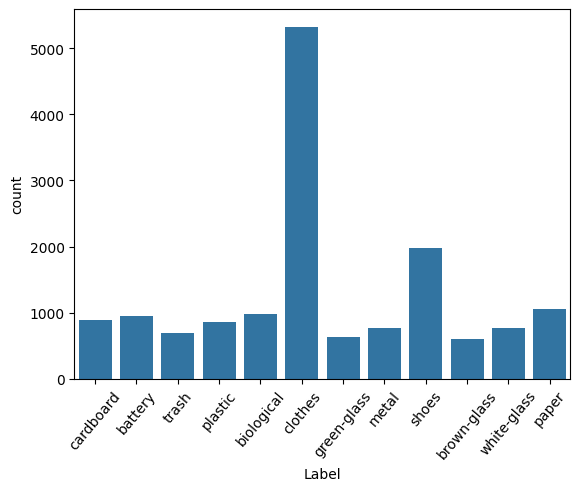

In [5]:
sns.countplot(x = dataframe["Label"])
plotter.xticks(rotation = 50);

<a id="4"></a>
# **<center><span style="color:#005dc4;">Split Dataset</span></center>**

In [6]:
train_data_dir =image_data
batch_size = 128                           # de 32 para 128
target_size = (224,224)
validation_split = 0.2

In [9]:

train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,                                                         # de 100 para 50
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=50,                                                         # de 200 para 100
    image_size=target_size,
    batch_size=batch_size,
)

# ✅ Extract class names BEFORE mapping
class_names = train.class_names
print("Class names:", class_names)

# ✅ ⬇️ ADD THESE LINES *RIGHT HERE*
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

train = train.map(lambda x, y: (preprocess_input(x), y))
validation = validation.map(lambda x, y: (preprocess_input(x), y))

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.
Class names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


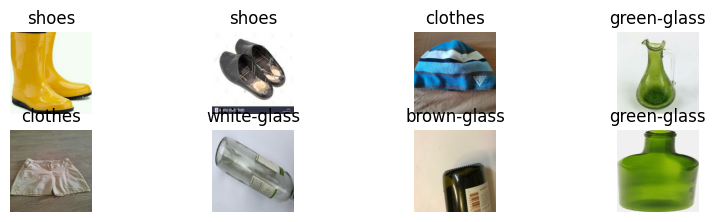

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a id="5"></a>
# **<center><span style="color:#005dc4;">Modeling</span></center>**

In [11]:
base_model = tf.keras.applications.EfficientNetV2B1(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten())
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(12,activation='softmax'))     #12 classes
keras_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b1 (Functional)  │ (None, 7, 7, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │       752,652 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,683,776 (29.31 MB)

 Trainable params: 752,652 (2.87 MB)

 Non-trainable params: 6,931,124 (26.44 MB)

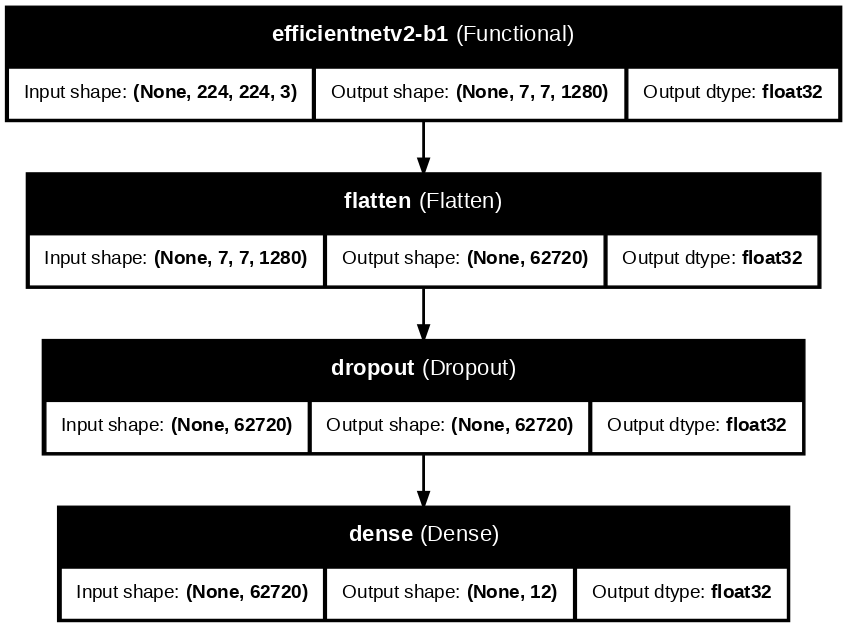

In [12]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=100)

In [13]:
checkpoint =ModelCheckpoint("my_keras_model.h5", save_best_only=True)

In [14]:
early_stopping =EarlyStopping(patience=10, restore_best_weights=True)    # patience de 5 para 10

In [15]:
keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
hist=keras_model.fit(train,epochs=3,validation_data=validation,callbacks=[checkpoint,early_stopping])

Epoch 1/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.8218 - loss: 0.9061

97/97 ━━━━━━━━━━━━━━━━━━━━ 429s 4s/step - accuracy: 0.8226 - loss: 0.9030 - val_accuracy: 0.9423 - val_loss: 0.3251
Epoch 2/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 54s 560ms/step - accuracy: 0.9715 - loss: 0.1690 - val_accuracy: 0.9449 - val_loss: 0.3773
Epoch 3/3
97/97 ━━━━━━━━━━━━━━━━━━━━ 64s 662ms/step - accuracy: 0.9798 - loss: 0.0966 - val_accuracy: 0.9575 - val_loss: 0.3263


In [18]:
# TensorFlow SavedModel format

keras_model.save("/content/drive/MyDrive/garbage_classifier.keras")

# **Load and Predict on a New Image**

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Predicted class: biological
Confidence: 1.00


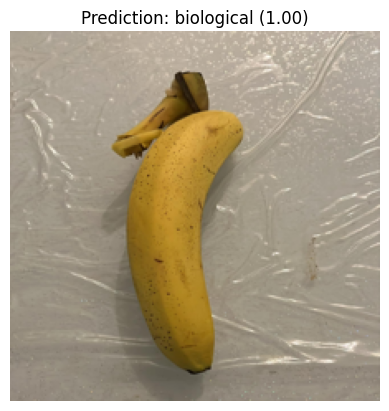

In [23]:
import numpy as np
from keras.models import load_model
from tensorflow.keras.preprocessing import image
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# 1️⃣ Load the trained model
from keras.saving import register_keras_serializable

# @register_keras_serializable()
# def softmax_v2(x):
    # return tf.nn.softmax(x)

# model = load_model("/content/drive/MyDrive/garbage_classifier.keras", custom_objects={"softmax_v2": softmax_v2})

model = load_model("/content/drive/MyDrive/garbage_classifier.keras")

# 3️⃣ Load and preprocess an image
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img = img.resize((224, 224))  # Same as model input size
    # img_array = np.array(img) / 255.0  # Normalize to [0,1]

    img_array = preprocess_input(np.array(img))

    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img, img_array

# Example image path
img_path = "/content/drive/MyDrive/banana.jpg" # Replace with the actual path to your image

# 4️⃣ Preprocess and predict
img, input_image = preprocess_image(img_path)
predictions = model.predict(input_image)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]
confidence = float(np.max(predictions))

# 5️⃣ Print result
print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

# 6️⃣ Show the image with prediction
plt.imshow(img)
plt.title(f"Prediction: {predicted_class} ({confidence:.2f})")
plt.axis('off')
plt.show()

In [47]:
print(model.output_shape)
print(class_names)

(None, 12)
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [17]:
score, acc = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 416ms/step - accuracy: 0.9856 - loss: 0.0711
Test Loss = 0.0775599554181099
Test Accuracy = 0.9848533868789673


In [18]:
hist_=pd.DataFrame(hist.history)
hist_

,accuracy,loss,val_accuracy,val_loss
0,0.895504,0.623808,0.976152,0.121555
1,0.971399,0.136978,0.984853,0.077560
2,0.980342,0.100320,0.986465,0.086401
3,0.986223,0.072461,0.988721,0.091622
4,0.985256,0.074705,0.985820,0.102177
5,0.986223,0.067889,0.989043,0.119795
6,0.989043,0.064788,0.985498,0.142422
7,0.986304,0.088681,0.986465,0.143099
8,0.989204,0.070804,0.989043,0.127939
9,0.989768,0.074010,0.988721,0.131625


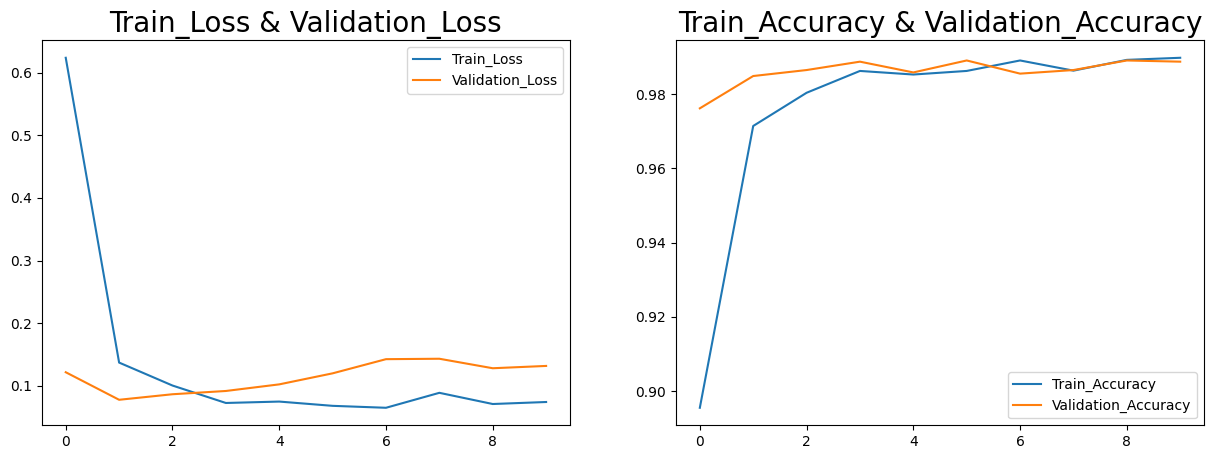

In [19]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [20]:
X_val,y_val,y_pred=[],[],[]
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.extend(images.numpy())
predictions=keras_model.predict(np.array(X_val))
for i in predictions:
    y_pred.append(np.argmax(i))
df=pd.DataFrame()
df['Actual'],df['Prediction']=y_val,y_pred
df

97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 123ms/step


,Actual,Prediction
0,10,10
1,4,4
2,1,1
3,4,4
4,11,11
...,...,...
3098,10,10
3099,3,3
3100,4,4
3101,4,4


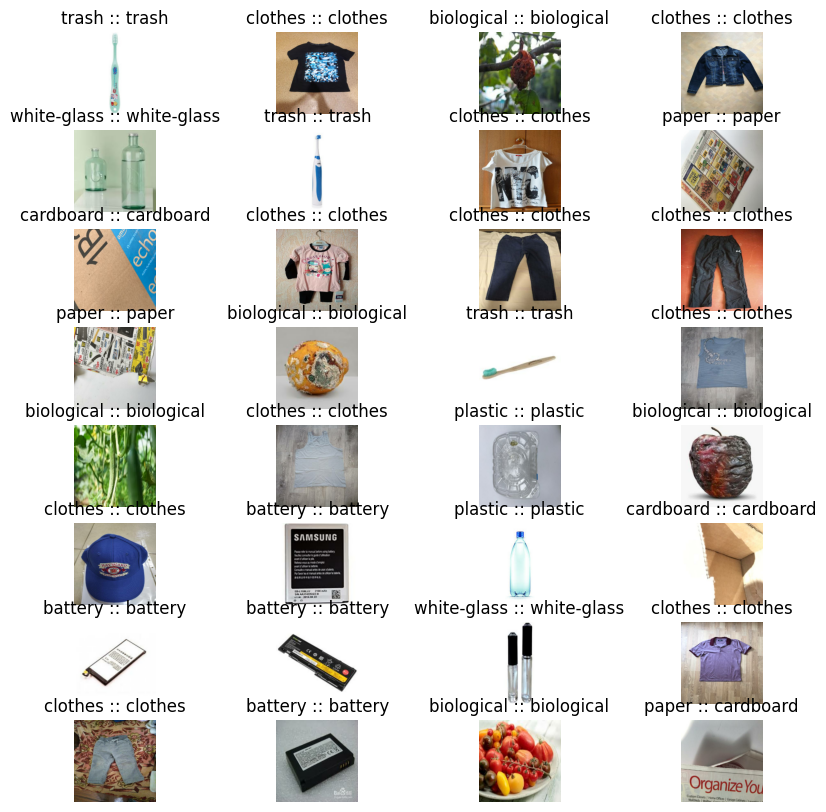

In [21]:
plt.figure(figsize=(10,10))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

<a id="6"></a>
# **<center><span style="color:#005dc4;">Confusion_matrix</span></center>**

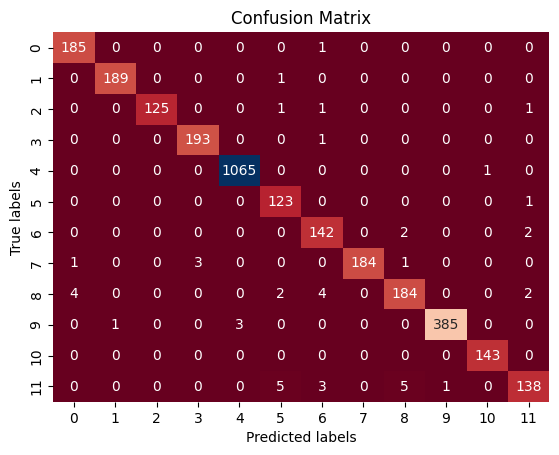

array([[ 185,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,
           0],
       [   0,  189,    0,    0,    0,    1,    0,    0,    0,    0,    0,
           0],
       [   0,    0,  125,    0,    0,    1,    1,    0,    0,    0,    0,
           1],
       [   0,    0,    0,  193,    0,    0,    1,    0,    0,    0,    0,
           0],
       [   0,    0,    0,    0, 1065,    0,    0,    0,    0,    0,    1,
           0],
       [   0,    0,    0,    0,    0,  123,    0,    0,    0,    0,    0,
           1],
       [   0,    0,    0,    0,    0,    0,  142,    0,    2,    0,    0,
           2],
       [   1,    0,    0,    3,    0,    0,    0,  184,    1,    0,    0,
           0],
       [   4,    0,    0,    0,    0,    2,    4,    0,  184,    0,    0,
           2],
       [   0,    1,    0,    0,    3,    0,    0,    0,    0,  385,    0,
           0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  143,
           0],
       [   0,    0,  

In [22]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM

<a id="7"></a>
# **<center><span style="color:#005dc4;">Accuracy</span></center>**

In [23]:
Acc = accuracy_score(y_val,y_pred)
print("accuracy is: {0:.4f}%".format(Acc * 100))

accuracy is: 98.4853%
